In [2]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [3]:
df = pd.read_csv("AQI_daily_final.csv")
df.head()

,Date,Overall AQI Value,Main Pollutant,Site Name (of Overall AQI),Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,NO2
0,01/01/2020,106,PM2.5,Bakersfield-California,06-029-0014,AQS,3,37,22,106,29
1,01/02/2020,99,PM2.5,Bakersfield-California,06-029-0014,AQS,3,34,24,99,23
2,01/03/2020,86,PM2.5,Bakersfield-California,06-029-0014,AQS,3,31,25,86,27
3,01/04/2020,78,PM2.5,Bakersfield-Golden / M St,06-029-0010,AQS,3,40,35,78,34
4,01/05/2020,73,PM2.5,Bakersfield-California,06-029-0014,AQS,5,36,15,73,20


In [4]:
df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Overall AQI Value,Main Pollutant,Site Name (of Overall AQI),Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,NO2
Date,,,,,,,,,,,
2020-01-01,01/01/2020,106,PM2.5,Bakersfield-California,06-029-0014,AQS,3,37,22,106,29
2020-01-02,01/02/2020,99,PM2.5,Bakersfield-California,06-029-0014,AQS,3,34,24,99,23
2020-01-03,01/03/2020,86,PM2.5,Bakersfield-California,06-029-0014,AQS,3,31,25,86,27
2020-01-04,01/04/2020,78,PM2.5,Bakersfield-Golden / M St,06-029-0010,AQS,3,40,35,78,34
2020-01-05,01/05/2020,73,PM2.5,Bakersfield-California,06-029-0014,AQS,5,36,15,73,20


<Axes: xlabel='Date'>

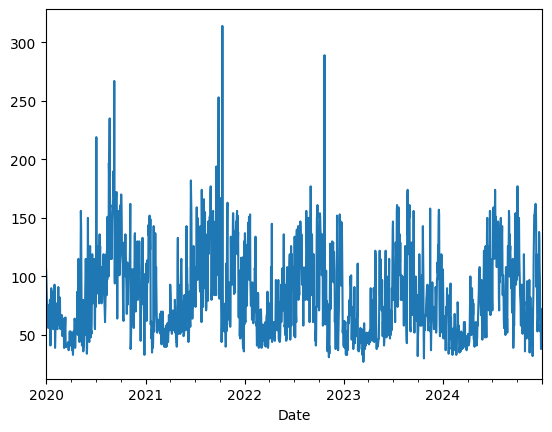

In [5]:
overall_AQI = df['Overall AQI Value']
overall_AQI.plot()

In [6]:
df.drop('Site Name (of Overall AQI)', axis=1, inplace=True)
df.head()

,Date,Overall AQI Value,Main Pollutant,Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,NO2
Date,,,,,,,,,,
2020-01-01,01/01/2020,106,PM2.5,06-029-0014,AQS,3,37,22,106,29
2020-01-02,01/02/2020,99,PM2.5,06-029-0014,AQS,3,34,24,99,23
2020-01-03,01/03/2020,86,PM2.5,06-029-0014,AQS,3,31,25,86,27
2020-01-04,01/04/2020,78,PM2.5,06-029-0010,AQS,3,40,35,78,34
2020-01-05,01/05/2020,73,PM2.5,06-029-0014,AQS,5,36,15,73,20


In [7]:
df['CO'] = pd.to_numeric(df['CO'], errors='coerce')
df['Ozone'] = pd.to_numeric(df['Ozone'], errors='coerce')
df['PM10'] = pd.to_numeric(df['PM10'], errors='coerce')
df['PM25'] = pd.to_numeric(df['PM25'], errors='coerce')
df['NO2'] = pd.to_numeric(df['NO2'], errors='coerce')
df.replace('-', np.nan, inplace=True)

df.ffill(inplace=True)

df.head()

,Date,Overall AQI Value,Main Pollutant,Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,NO2
Date,,,,,,,,,,
2020-01-01,01/01/2020,106,PM2.5,06-029-0014,AQS,3.0,37,22,106,29
2020-01-02,01/02/2020,99,PM2.5,06-029-0014,AQS,3.0,34,24,99,23
2020-01-03,01/03/2020,86,PM2.5,06-029-0014,AQS,3.0,31,25,86,27
2020-01-04,01/04/2020,78,PM2.5,06-029-0010,AQS,3.0,40,35,78,34
2020-01-05,01/05/2020,73,PM2.5,06-029-0014,AQS,5.0,36,15,73,20


In [8]:
scaler = MinMaxScaler()
columns_to_normalize = ['CO', 'Ozone', 'PM10', 'PM25', 'NO2']
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df.head()

,Date,Overall AQI Value,Main Pollutant,Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,NO2
Date,,,,,,,,,,
2020-01-01,01/01/2020,106,PM2.5,06-029-0014,AQS,0.117647,0.081967,0.067093,0.404858,0.393443
2020-01-02,01/02/2020,99,PM2.5,06-029-0014,AQS,0.117647,0.065574,0.073482,0.376518,0.295082
2020-01-03,01/03/2020,86,PM2.5,06-029-0014,AQS,0.117647,0.049180,0.076677,0.323887,0.360656
2020-01-04,01/04/2020,78,PM2.5,06-029-0010,AQS,0.117647,0.098361,0.108626,0.291498,0.475410
2020-01-05,01/05/2020,73,PM2.5,06-029-0014,AQS,0.235294,0.076503,0.044728,0.271255,0.245902


In [9]:
def df_to_x_y(df, window_size):  # convert dataframe to x and y for array
    df_as_np = df.to_numpy()  # convert dataframe to numpy array
    x = []
    y = []
    indices = []

    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
        indices.append(df.index[i])
    return np.array(x), np.array(y), np.array(indices)

In [10]:
WINDOW_SIZE = 365
X, y, indices = df_to_x_y(overall_AQI, window_size=WINDOW_SIZE)
X.shape, y.shape

((1462, 365, 1), (1462,))

In [11]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test, indices_train_val, indices_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(
    X_train_val, y_train_val, indices_train_val, test_size=0.25, random_state=42
)

In [12]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (876, 365, 1)
y_train shape: (876,)
X_val shape: (293, 365, 1)
y_val shape: (293,)
X_test shape: (293, 365, 1)
y_test shape: (293,)


In [13]:
model = Sequential()
model.add(InputLayer(input_shape=(WINDOW_SIZE, 1)))
model.add(LSTM(64))
model.add(Dense(8, activation='relu'   ))
model.add(Dense(1, activation='linear'))
model.summary()

c:\Users\Malsha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
cp = ModelCheckpoint('best_model.h5', save_best_only=True) 
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=[RootMeanSquaredError()]
)

In [15]:
model.fit(X_train, y_train,
          validation_data=(X_val, y_val), epochs=100, callbacks=[cp])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 8278.3255 - root_mean_squared_error: 90.9577

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - loss: 7921.4932 - root_mean_squared_error: 89.0028 - val_loss: 8213.3252 - val_root_mean_squared_error: 90.6274
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 7817.0384 - root_mean_squared_error: 88.3995

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - loss: 7534.0068 - root_mean_squared_error: 86.7987 - val_loss: 7672.8159 - val_root_mean_squared_error: 87.5946
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 6742.6297 - root_mean_squared_error: 82.1086

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - loss: 6792.5493 - root_mean_squared_error: 82.4169 - val_loss: 6693.1060 - val_root_mean_squared_error: 81.8114
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 6155.4375 - root_mean_squared_error: 78.4221

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 5954.3447 - root_mean_squared_error: 77.1644 - val_loss: 5987.0928 - val_root_mean_squared_error: 77.3763
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 5452.9116 - root_mean_squared_error: 73.8361

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - loss: 5277.3818 - root_mean_squared_error: 72.6456 - val_loss: 5257.9893 - val_root_mean_squared_error: 72.5120
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 4785.3363 - root_mean_squared_error: 69.1627

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - loss: 4560.6870 - root_mean_squared_error: 67.5329 - val_loss: 4522.5176 - val_root_mean_squared_error: 67.2497
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 3892.2531 - root_mean_squared_error: 62.3784

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - loss: 3907.1133 - root_mean_squared_error: 62.5069 - val_loss: 3880.4468 - val_root_mean_squared_error: 62.2932
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 3404.8842 - root_mean_squared_error: 58.3251

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - loss: 3291.8560 - root_mean_squared_error: 57.3747 - val_loss: 3268.5549 - val_root_mean_squared_error: 57.1713
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 2715.6722 - root_mean_squared_error: 52.0463

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - loss: 2782.2104 - root_mean_squared_error: 52.7467 - val_loss: 2773.4907 - val_root_mean_squared_error: 52.6639
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 2176.6213 - root_mean_squared_error: 46.6463

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 2335.0444 - root_mean_squared_error: 48.3223 - val_loss: 2358.7314 - val_root_mean_squared_error: 48.5668
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 2024.0583 - root_mean_squared_error: 44.9824

28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - loss: 2004.6517 - root_mean_squared_error: 44.7733 - val_loss: 2037.2489 - val_root_mean_squared_error: 45.1359
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 1736.9626 - root_mean_squared_error: 41.6167

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 1749.6543 - root_mean_squared_error: 41.8289 - val_loss: 1798.8182 - val_root_mean_squared_error: 42.4125
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 1688.5164 - root_mean_squared_error: 41.0590

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - loss: 1567.4327 - root_mean_squared_error: 39.5908 - val_loss: 1626.4121 - val_root_mean_squared_error: 40.3288
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 1492.5789 - root_mean_squared_error: 38.6026

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - loss: 1438.9774 - root_mean_squared_error: 37.9339 - val_loss: 1503.3988 - val_root_mean_squared_error: 38.7737
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1345.0707 - root_mean_squared_error: 36.6622

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - loss: 1322.3699 - root_mean_squared_error: 36.3644 - val_loss: 1379.2428 - val_root_mean_squared_error: 37.1382
Epoch 16/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 1286.2793 - root_mean_squared_error: 35.8193

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - loss: 1176.3159 - root_mean_squared_error: 34.2975 - val_loss: 1258.4373 - val_root_mean_squared_error: 35.4745
Epoch 17/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 1069.8711 - root_mean_squared_error: 32.6657

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - loss: 1058.8088 - root_mean_squared_error: 32.5393 - val_loss: 1156.8839 - val_root_mean_squared_error: 34.0130
Epoch 18/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 955.6093 - root_mean_squared_error: 30.8838

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - loss: 962.2210 - root_mean_squared_error: 31.0197 - val_loss: 1068.4232 - val_root_mean_squared_error: 32.6867
Epoch 19/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 900.7204 - root_mean_squared_error: 29.9813

28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - loss: 887.0031 - root_mean_squared_error: 29.7826 - val_loss: 1003.8926 - val_root_mean_squared_error: 31.6843
Epoch 20/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 814.1973 - root_mean_squared_error: 28.5132

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - loss: 827.8735 - root_mean_squared_error: 28.7728 - val_loss: 964.1458 - val_root_mean_squared_error: 31.0507
Epoch 21/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 854.9930 - root_mean_squared_error: 29.1071

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - loss: 780.9428 - root_mean_squared_error: 27.9454 - val_loss: 915.0587 - val_root_mean_squared_error: 30.2499
Epoch 22/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 697.6547 - root_mean_squared_error: 26.4012

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 735.7564 - root_mean_squared_error: 27.1248 - val_loss: 879.6445 - val_root_mean_squared_error: 29.6588
Epoch 23/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 694.0330 - root_mean_squared_error: 26.3059

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - loss: 703.7158 - root_mean_squared_error: 26.5276 - val_loss: 845.0340 - val_root_mean_squared_error: 29.0695
Epoch 24/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 728.0466 - root_mean_squared_error: 26.9526

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - loss: 678.6340 - root_mean_squared_error: 26.0506 - val_loss: 828.7433 - val_root_mean_squared_error: 28.7879
Epoch 25/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 641.0107 - root_mean_squared_error: 25.2997

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - loss: 658.6613 - root_mean_squared_error: 25.6644 - val_loss: 823.6750 - val_root_mean_squared_error: 28.6997
Epoch 26/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 609.1814 - root_mean_squared_error: 24.6294

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - loss: 646.5452 - root_mean_squared_error: 25.4273 - val_loss: 802.6827 - val_root_mean_squared_error: 28.3317
Epoch 27/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 581.1921 - root_mean_squared_error: 24.1008

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 629.8075 - root_mean_squared_error: 25.0960 - val_loss: 786.4267 - val_root_mean_squared_error: 28.0433
Epoch 28/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - loss: 620.6836 - root_mean_squared_error: 24.9135 - val_loss: 793.3486 - val_root_mean_squared_error: 28.1664
Epoch 29/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 573.1031 - root_mean_squared_error: 23.8911

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - loss: 607.4695 - root_mean_squared_error: 24.6469 - val_loss: 766.8477 - val_root_mean_squared_error: 27.6920
Epoch 30/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 592.7936 - root_mean_squared_error: 24.3010

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - loss: 598.7451 - root_mean_squared_error: 24.4693 - val_loss: 758.2799 - val_root_mean_squared_error: 27.5369
Epoch 31/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - loss: 588.6274 - root_mean_squared_error: 24.2616 - val_loss: 765.3585 - val_root_mean_squared_error: 27.6651
Epoch 32/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 622.9188 - root_mean_squared_error: 24.8651

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - loss: 586.1594 - root_mean_squared_error: 24.2107 - val_loss: 745.6821 - val_root_mean_squared_error: 27.3072
Epoch 33/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - loss: 576.6035 - root_mean_squared_error: 24.0126 - val_loss: 771.3184 - val_root_mean_squared_error: 27.7726
Epoch 34/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 533.9530 - root_mean_squared_error: 23.0381

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - loss: 575.0331 - root_mean_squared_error: 23.9798 - val_loss: 735.1929 - val_root_mean_squared_error: 27.1144
Epoch 35/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 527.7242 - root_mean_squared_error: 22.9567

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 572.6203 - root_mean_squared_error: 23.9295 - val_loss: 731.3984 - val_root_mean_squared_error: 27.0444
Epoch 36/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 516.1242 - root_mean_squared_error: 22.6656

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - loss: 566.7007 - root_mean_squared_error: 23.8055 - val_loss: 729.0118 - val_root_mean_squared_error: 27.0002
Epoch 37/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - loss: 563.6431 - root_mean_squared_error: 23.7412 - val_loss: 733.9775 - val_root_mean_squared_error: 27.0920
Epoch 38/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 538.2191 - root_mean_squared_error: 23.1852

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - loss: 562.2556 - root_mean_squared_error: 23.7119 - val_loss: 724.8545 - val_root_mean_squared_error: 26.9231
Epoch 39/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 510.2312 - root_mean_squared_error: 22.5645

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - loss: 560.3358 - root_mean_squared_error: 23.6714 - val_loss: 724.3359 - val_root_mean_squared_error: 26.9135
Epoch 40/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 537.5732 - root_mean_squared_error: 23.1107

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 556.6066 - root_mean_squared_error: 23.5925 - val_loss: 721.2033 - val_root_mean_squared_error: 26.8552
Epoch 41/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 556.5479 - root_mean_squared_error: 23.5680

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - loss: 551.3095 - root_mean_squared_error: 23.4800 - val_loss: 720.4030 - val_root_mean_squared_error: 26.8403
Epoch 42/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 475.2097 - root_mean_squared_error: 21.7586

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - loss: 553.8907 - root_mean_squared_error: 23.5349 - val_loss: 717.1098 - val_root_mean_squared_error: 26.7789
Epoch 43/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 553.4196 - root_mean_squared_error: 23.4887

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 547.0991 - root_mean_squared_error: 23.3901 - val_loss: 715.5604 - val_root_mean_squared_error: 26.7500
Epoch 44/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 573.8928 - root_mean_squared_error: 23.9198

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - loss: 566.1805 - root_mean_squared_error: 23.7945 - val_loss: 711.4429 - val_root_mean_squared_error: 26.6729
Epoch 45/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - loss: 568.7628 - root_mean_squared_error: 23.8487 - val_loss: 723.1777 - val_root_mean_squared_error: 26.8920
Epoch 46/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - loss: 557.0401 - root_mean_squared_error: 23.6017 - val_loss: 728.1865 - val_root_mean_squared_error: 26.9849
Epoch 47/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - loss: 550.6247 - root_mean_squared_error: 23.4654 - val_loss: 715.6576 - val_root_mean_squared_error: 26.7518
Epoch 48/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 543.1926 - root_mean_squared_error: 23.3065 - val_loss: 712.2438 - val_root_mean_squared_error: 26.6879
Epoch 49/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - loss: 540.6912 - root_mean_squared_error: 23.2528 - val_loss: 720.2100 - val_root_mean_squared_error: 26.8367
Epoch 50/100
28/2

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - loss: 532.9745 - root_mean_squared_error: 23.0862 - val_loss: 704.9934 - val_root_mean_squared_error: 26.5517
Epoch 59/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 535.2484 - root_mean_squared_error: 23.1354 - val_loss: 712.7756 - val_root_mean_squared_error: 26.6979
Epoch 60/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - loss: 529.3696 - root_mean_squared_error: 23.0080 - val_loss: 712.1731 - val_root_mean_squared_error: 26.6866
Epoch 61/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - loss: 530.2491 - root_mean_squared_error: 23.0271 - val_loss: 725.3515 - val_root_mean_squared_error: 26.9324
Epoch 62/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 533.0447 - root_mean_squared_error: 23.0878 - val_loss: 728.3541 - val_root_mean_squared_error: 26.9880
Epoch 63/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - loss: 530.3083 - root_mean_squared_error: 23.0284 - val_loss: 712.9909 - val_root_mean_squared_error: 26.7019
Epoch 64/100
28/2

In [16]:
model = load_model("best_model.h5")


In [17]:
print(df.index)
print(indices_test[:10])


DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=1827, freq=None)
[Timestamp('2022-06-11 00:00:00') Timestamp('2023-01-11 00:00:00')
 Timestamp('2021-02-17 00:00:00') Timestamp('2021-06-06 00:00:00')
 Timestamp('2022-11-02 00:00:00') Timestamp('2021-09-06 00:00:00')
 Timestamp('2020-08-06 00:00:00') Timestamp('2023-03-07 00:00:00')
 Timestamp('2021-10-11 00:00:00') Timestamp('2022-06-06 00:00:00')]


In [19]:
y_pred = model.predict(X_test).flatten()

# Use the timestamps in indices_test directly as the date index.
# Do not overwrite the original `df` — create `results_df` (used by downstream cells).
date_index = pd.to_datetime(indices_test)

# optional sanity check (can be removed)
assert len(date_index) == len(y_test) == len(y_pred)

results_df = pd.DataFrame({'Date': date_index, 'y_test': y_test, 'y_pred': y_pred})
results_df.set_index('Date', inplace=True)
results_df.sort_index(ascending=True, inplace=True)

results_df

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


,y_test,y_pred
Date,,
2020-01-16,146,126.028465
2020-01-24,47,69.721573
2020-01-30,44,53.061401
2020-01-31,64,53.490646
2020-02-02,59,113.867760
...,...,...
2023-12-16,59,66.376778
2023-12-21,138,103.651756
2023-12-22,129,122.070107


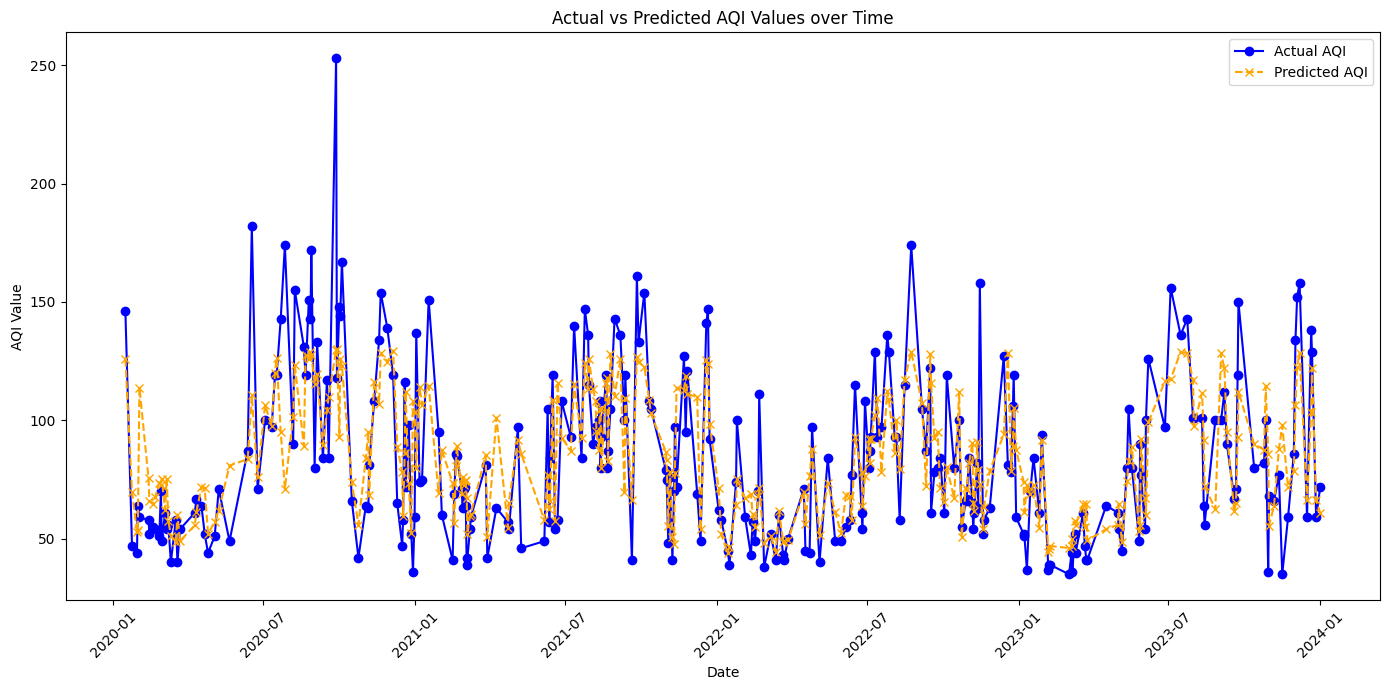

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['y_test'], label='Actual AQI', color='blue',marker = 'o')
plt.plot(results_df.index, results_df['y_pred'], label='Predicted AQI', color='orange',linestyle='--', marker = 'x' )
plt.title('Actual vs Predicted AQI Values over Time')
plt.xlabel('Date')
plt.ylabel('AQI Value') 
plt.xticks(rotation=45)    
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
MAE = mean_absolute_error(results_df['y_test'], results_df['y_pred'])
print("Mean Absolute Error (MAE):", MAE)


Mean Absolute Error (MAE): 17.27216339111328


In [22]:
MSE = mean_squared_error(results_df['y_test'], results_df['y_pred'])
print("Mean Squared Error (MSE):", MSE) #MSE

Mean Squared Error (MSE): 568.2476806640625


In [23]:
R2= r2_score(results_df['y_test'], results_df['y_pred'])
print("R-squared (R2):", R2)

R-squared (R2): 0.5602200627326965


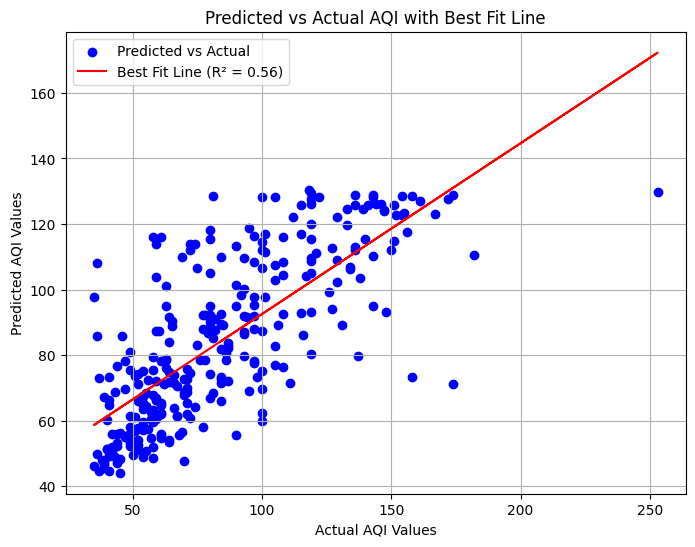

In [ ]:
# Fit best fit line
model_line = LinearRegression()
model_line.fit(y_test.reshape(-1, 1), y_pred)
y_fit = model_line.predict(y_test.reshape(-1, 1))

# Calculate R² score
R2 = r2_score(y_pred, y_fit)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='red', label='Predicted vs Actual')
plt.plot(y_test, y_fit, color='blue', label=f'Best Fit Line (R² = {R2:.2f})')
plt.xlabel('Actual AQI Values')
plt.ylabel('Predicted AQI Values')
plt.title('Predicted vs Actual AQI with Best Fit Line')
plt.legend()
plt.grid(True)
plt.show()
